In [114]:
%matplotlib notebook
# Import statements
from glob import glob
import os
import imageio
from astropy.io import fits
from ccdproc import ImageFileCollection
import numpy as np
import matplotlib.pyplot as plt

plt.rc('text', usetex = True) # Use LaTeX font in plots
plt.rcParams['text.latex.preamble'] = r'\usepackage{gensymb}'
# r'\usepackage{sansmath}'
# r'\sansmath'

### 0. Convert bitmap files to FITS files manually.

In [115]:
def bmp2fits(directory):
    # Pass this function a directory that contains bitmap files (even within another directory)
    # and it will create FITS versions of those bitmap files.
    filenames = glob('*.bmp') # Get filenames of any contained bitmap files
    filenames_noend = [] # Initialize list of files with ending removed
    for filename in filenames: # Loop over files
        filenames_noend.append(os.path.splitext(filename)[0]) # Remove file endings and append to new list

    for filename in filenames_noend: # Loop over files with no endings
        im = imageio.imread(filename+'.bmp') # Read in each file, adding the ending back
        hdu = fits.PrimaryHDU(im) # Create a HDU from the image
        hdu.writeto(filename+'.fits', overwrite=True) # Export to FITS

In [116]:
# Convert bitmap files to FITS files, only need to run once
# bmp2fits('pepito_star_spectra')

In [117]:
# Import spectra, dark frames, and flat frames
# Have to do this manually because bitmap files do not have FITS headers, so my usual method doesn't work
directory = 'pepito_star_spectra' # Define directory with images
ic_aldebaran = ImageFileCollection(directory, keywords='*', glob_include='aldebaran*') # Get Aldebaran frames
ic_deneb = ImageFileCollection(directory, keywords='*', glob_include='deneb*') # Get Deneb frames
ic_mirach = ImageFileCollection(directory, keywords='*', glob_include='mirach*') # Get Mirach frames
ic_darks_3s = ImageFileCollection(directory, keywords='*', glob_include='dark_3*') # Get dark frames
ic_darks_8s = ImageFileCollection(directory, keywords='*', glob_include='dark_8*') # Get dark frames
ic_darks_20p5s = ImageFileCollection(directory, keywords='*', glob_include='dark_20p5*') # Get dark frames
ic_flats = ImageFileCollection(directory, keywords='*', glob_include='flat*') # Get flat frames

### 0.1. Reduce the data.

The flat field images for these data are not good. Dark subtraction of the median-combined flat field image yields an image with a median of 0, which should not be the case, as the flat field image should be brighter than the dark frame. This could be due to the fact that these were saved as bitmap images, which only have 255 possible signal values, while FITS files have the freedom to store the signal value output by the CCD. Therefore, I will not be performing flat-field corrections on these data.

In [202]:
def make_final_dark(ic):
    # Pass this function an image collection of dark frames
    # and it will create a final dark frame.
    lst = []
    for i in range(len(ic.files)):
        lst.append(fits.getdata(directory+'/'+ic.files[i]))
    arr = np.array(lst)
    final_dark = np.median(arr, axis=0)
    return final_dark

# Get final dark frames for each exposure time
final_dark_3s = make_final_dark(ic_darks_3s)
final_dark_8s = make_final_dark(ic_darks_8s)
final_dark_20p5s = make_final_dark(ic_darks_20p5s)
# plt.imshow(final_dark_20p5s)

def make_norm_final_flat(ic, final_dark):
    # Pass this function an image collection of flat frames and a final dark frame
    # and it will create a normalized final flat field image.
    lst = []
    for i in range(len(ic.files)):
        lst.append(fits.getdata(directory+'/'+ic.files[i]))
    arr = np.array(lst)
    median_combined_flat = np.median(arr, axis=0)
    print("Median of median-combined flat:",np.median(median_combined_flat))
    final_flat = median_combined_flat - final_dark # These should have the same exposure time
    print("Median of dark-subtracted final flat:",np.nanmedian(final_flat))
    print(final_flat)
    norm_final_flat = final_flat/np.nanmedian(final_flat)
    return norm_final_flat

# Get normalized final flat field image
norm_final_flat = make_norm_final_flat(ic_flats, final_dark_20p5s) # Make sure they have the same exptime
# plt.imshow(norm_final_flat)
    
def get_star_images(ic):
    lst = []
    for i in range(len(ic.files)):
        lst.append(fits.getdata(directory+'/'+ic.files[i]))
    image_arr = np.array(lst)
    return image_arr

# Get star images for each star
aldebaran_images = get_star_images(ic_aldebaran)
deneb_images = get_star_images(ic_deneb)
mirach_images = get_star_images(ic_mirach)

Median of median-combined flat: 98.0
Median of dark-subtracted final flat: 0.0
[[ -6.  -2. -11. ...  -8.  -2.  -2.]
 [ -5.   0.  -8. ...  -4.  -2.   3.]
 [ -4.   0.   5. ...   2.   1.  -2.]
 ...
 [ -9.  -1.  -4. ...   3.   4.  -5.]
 [ -6.   2.   1. ...   0.  -5.  -2.]
 [  3. -10.   6. ...   2.   5.  -3.]]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


Here, I'll perform dark subtraction on the star images.

In [119]:
# Dark-subtract the star images
aldebaran_images_d = aldebaran_images - final_dark_3s[np.newaxis,:,:] # Use array broadcasting to dark-subtract
deneb_images_d = deneb_images - final_dark_3s[np.newaxis,:,:] # Use array broadcasting to dark-subtract
mirach_images_d = mirach_images - final_dark_8s[np.newaxis,:,:] # Use array broadcasting to dark-subtract

### 1. Determine a wavelength solution using the arc lamp spectra.

I will use my results from the Pepito wavelength calibration homework assignment. I used the lamp files ending in "2" to do this. My wavelength solution is in the accompanying file `pepito_all_lines.csv`.

### 2. Extract spectra of the stellar targets.

In [122]:
def extract_spectrum(star_images, ymin, ymax, single=False):
    # Given an input of the star images and y-axis boundaries of the location
    # of the spectrum, median-combine and extract the spectra
    if single == False:
        star_final_image = np.median(star_images, axis=0) # Median combine the frames for the star
    elif single == True:
        star_final_image = star_images
    star_rect = star_final_image[ymin:ymax,:] # Access the section of the image that has the spectrum on it
#     plt.figure(dpi = 100)
#     plt.rc('font', family='serif')
#     plt.imshow(star_rect)
    star_rect_collapsed = np.mean(star_rect, axis=0) # Collapse along the vertical (slit) axis
    star_detector_loc = np.arange(len(star_rect_collapsed)) # Create an array of pixel indices
    return (star_detector_loc, star_rect_collapsed)

In [123]:
aldebaran_detector_loc, aldebaran_collapsed = extract_spectrum(aldebaran_images_d, 430, 463)
deneb_detector_loc, deneb_collapsed = extract_spectrum(deneb_images_d[0], 479, 506, True) # Only use first image
mirach_detector_loc, mirach_collapsed = extract_spectrum(mirach_images_d, 430, 463)

In [124]:
def plot_raw_spectrum(detector_loc, spectrum_collapsed, star_name):
    # Plot the spectrum against detector position
    plt.figure(dpi = 100)
    plt.rc('font', family='serif')
    plt.plot(detector_loc, spectrum_collapsed)
    plt.xlabel(r'Detector coordinate (pixels)')
    plt.ylabel(r'Flux (ADU)')
    plt.title(star_name+" Spectrum (detector coordinates)")
    plt.show()

<IPython.core.display.Javascript object>


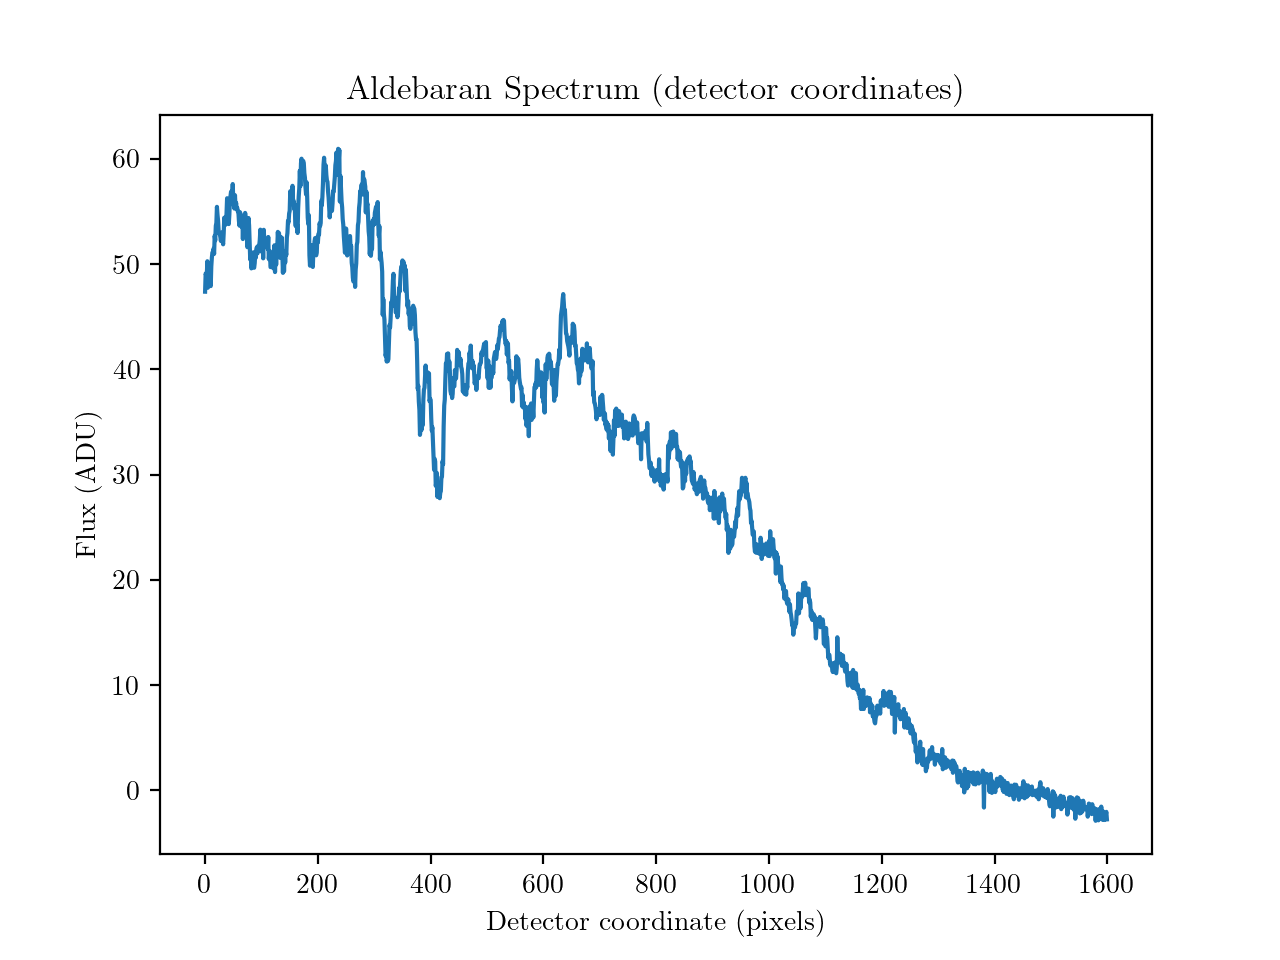

<IPython.core.display.Javascript object>


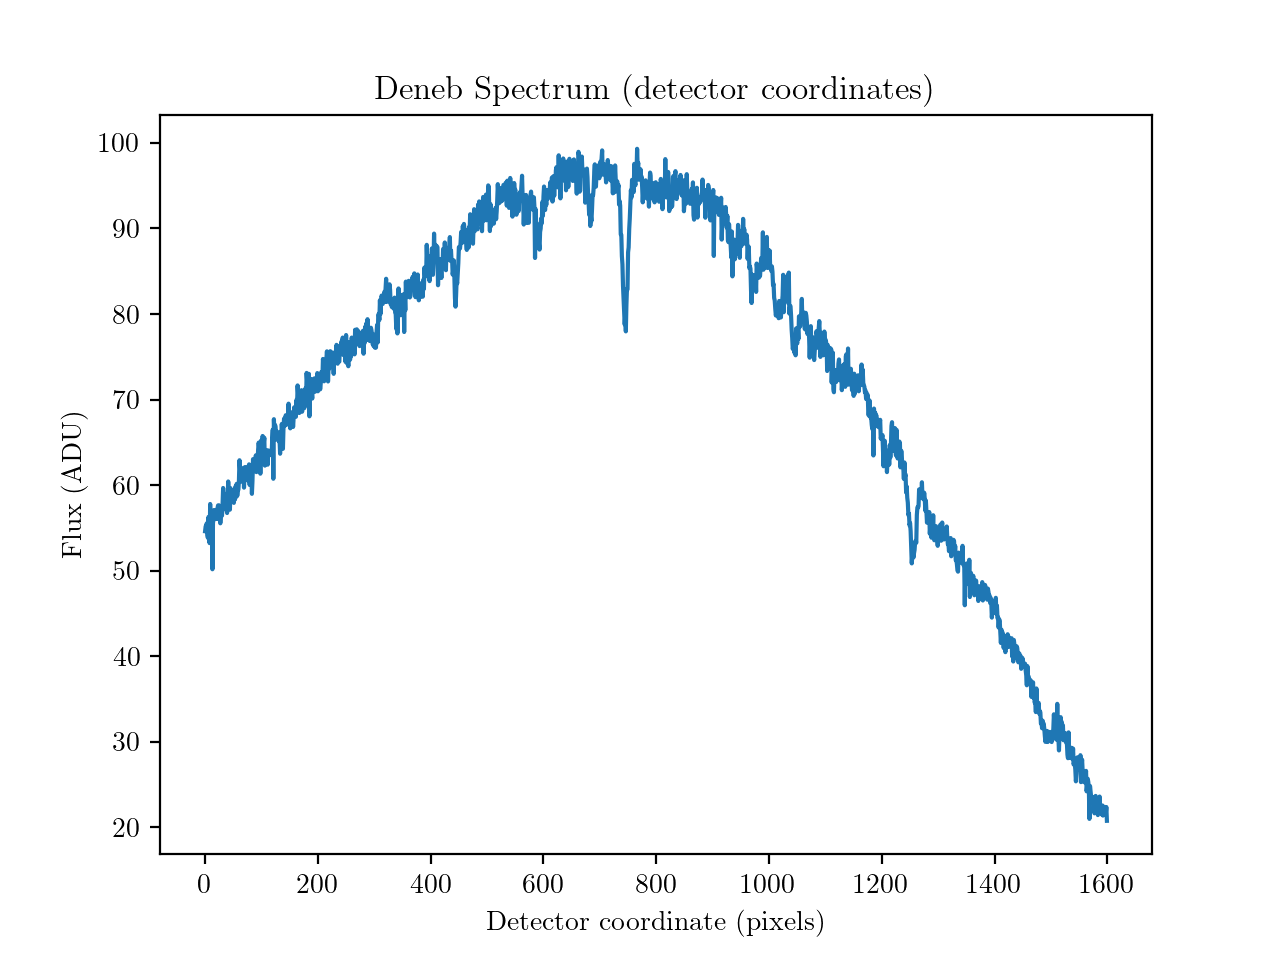

<IPython.core.display.Javascript object>


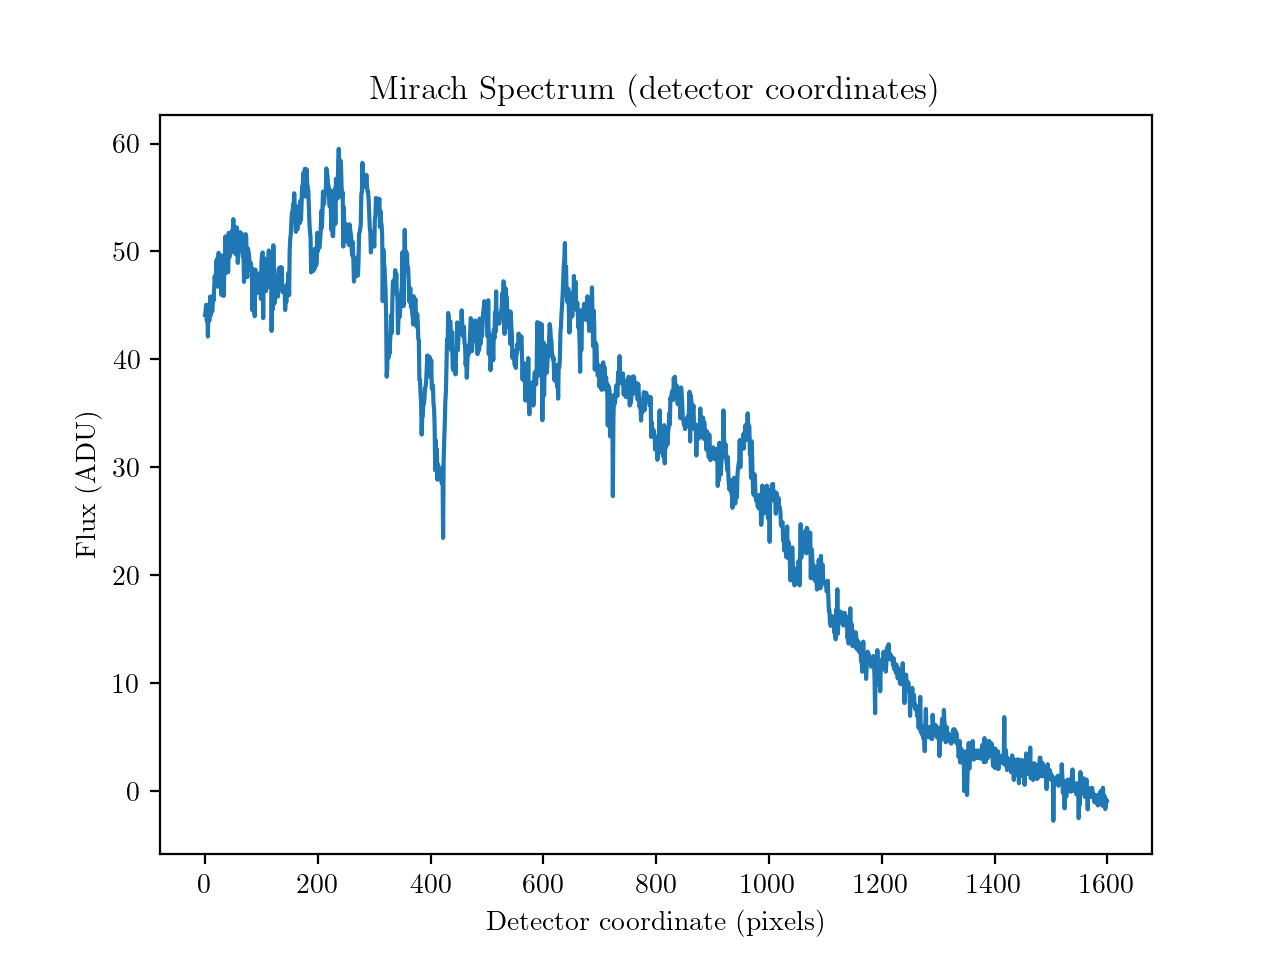

In [126]:
plot_raw_spectrum(aldebaran_detector_loc, aldebaran_collapsed, "Aldebaran")
plot_raw_spectrum(deneb_detector_loc, deneb_collapsed, "Deneb")
plot_raw_spectrum(mirach_detector_loc, mirach_collapsed, "Mirach")

### 3. Use these to create wavelength‐calibrated spectra of the targets

In [127]:
def get_calibration(line_list, polyfit_degree):
    line_data = np.genfromtxt(line_list, names=True, delimiter=',', dtype=float) # Load our file
    wavelengths, locations = line_data['wl_AA'], line_data['loc_px']
    argsort = np.argsort(locations) # Sort wavelengths by detector locations to prevent issues later on
    locations = locations[argsort] # Apply indices to arrays
    wavelengths = wavelengths[argsort] # Apply indices to arrays
    coeffs = np.polyfit(locations, wavelengths, deg=polyfit_degree) # Determine coeffs for a polynomial fit
    # print(coeffs) # Very small valued coefficients indicate you're probably over-fitting
    polynomial = np.poly1d(coeffs) # Create a poly1d object from our coefficients for np.polyval to use
    fitted_wavelengths = np.polyval(polynomial, locations) # Get wavelength for detector coordinates
    return fitted_wavelengths, polynomial

In [128]:
all_fitted_wavelengths, all_polynomial = get_calibration('pepito_all_lines.csv', 5)

In [129]:
def calibrate_spectrum(detector_loc, polynomial):
    # Wavelength-calibrate a spectrum
    wavelength = np.polyval(all_polynomial, aldebaran_detector_loc)
    return wavelength

In [130]:
aldebaran_wavelength = calibrate_spectrum(aldebaran_detector_loc, all_polynomial)
deneb_wavelength = calibrate_spectrum(deneb_detector_loc, all_polynomial)
mirach_wavelength = calibrate_spectrum(mirach_detector_loc, all_polynomial)

In [359]:
def plot_cal_spectrum(wavelength, spectrum_collapsed, star_name, file_name):
    # Plot a spectrum against wavelength
    plt.figure(dpi = 100, figsize=(7,4.5))
    plt.rc('font', family='serif')
    plt.plot(wavelength, spectrum_collapsed, color='xkcd:orange', lw=1)
    plt.xlabel(r'Wavelength (\AA)')
    plt.ylabel(r'Flux (ADU)')
    plt.title(star_name+" Initial Spectrum (wavelength-calibrated)")
    plt.tight_layout()
    plt.savefig(file_name, dpi=250, facecolor='w', edgecolor='w')
    plt.show()

<IPython.core.display.Javascript object>


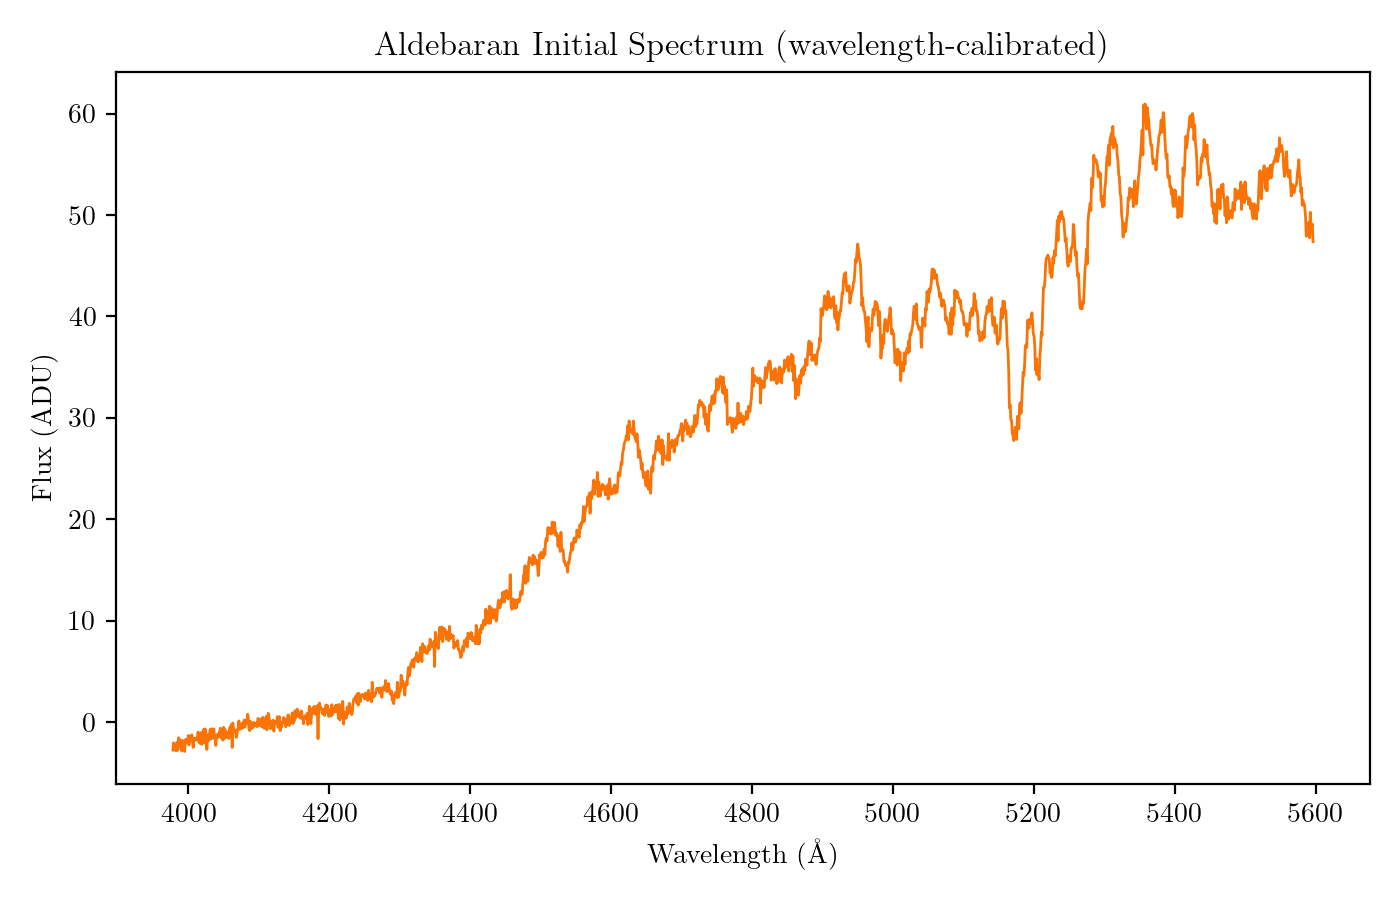

<IPython.core.display.Javascript object>


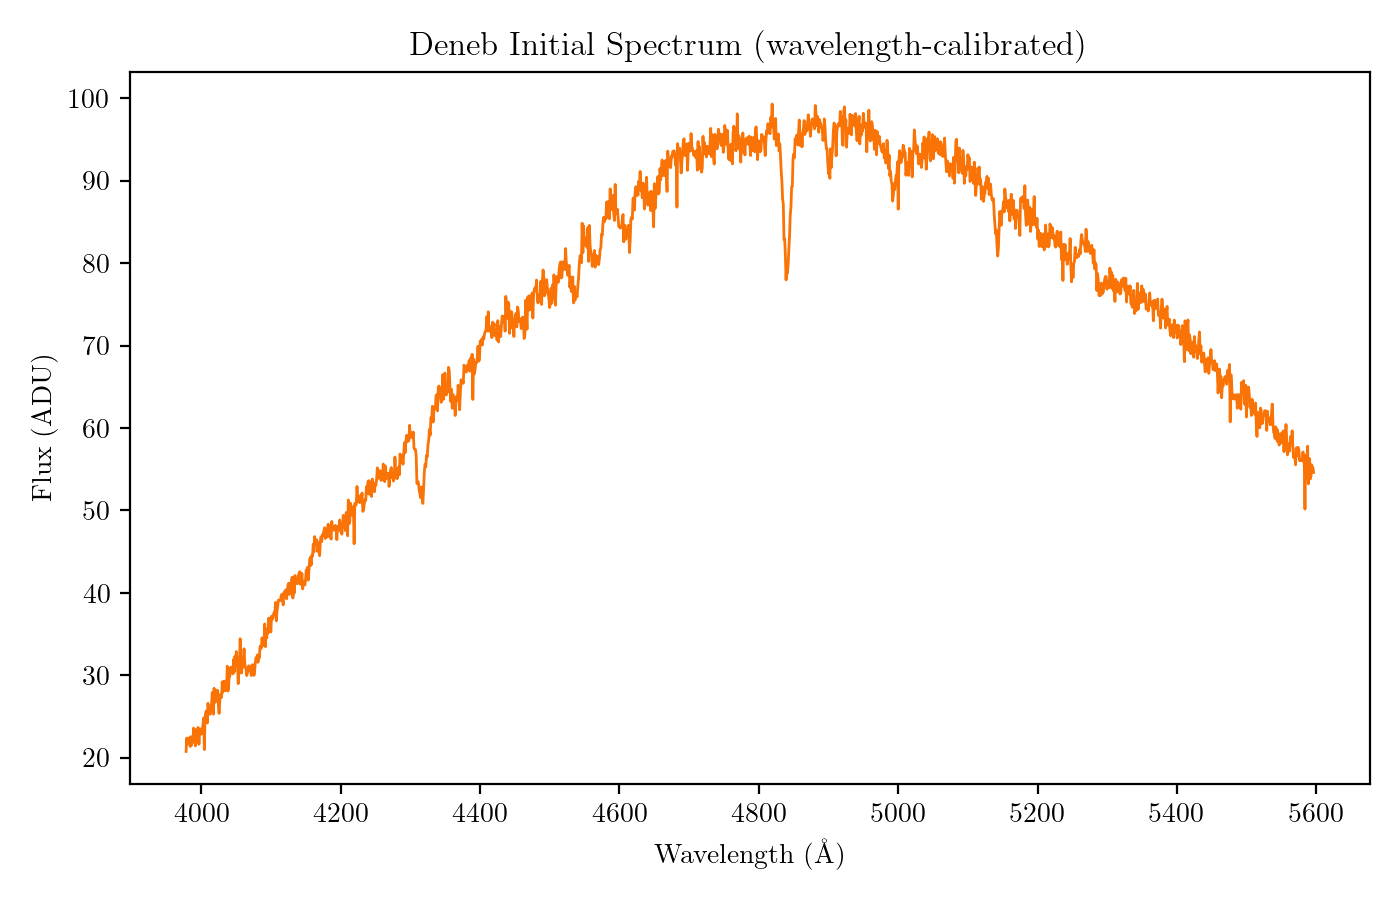

<IPython.core.display.Javascript object>


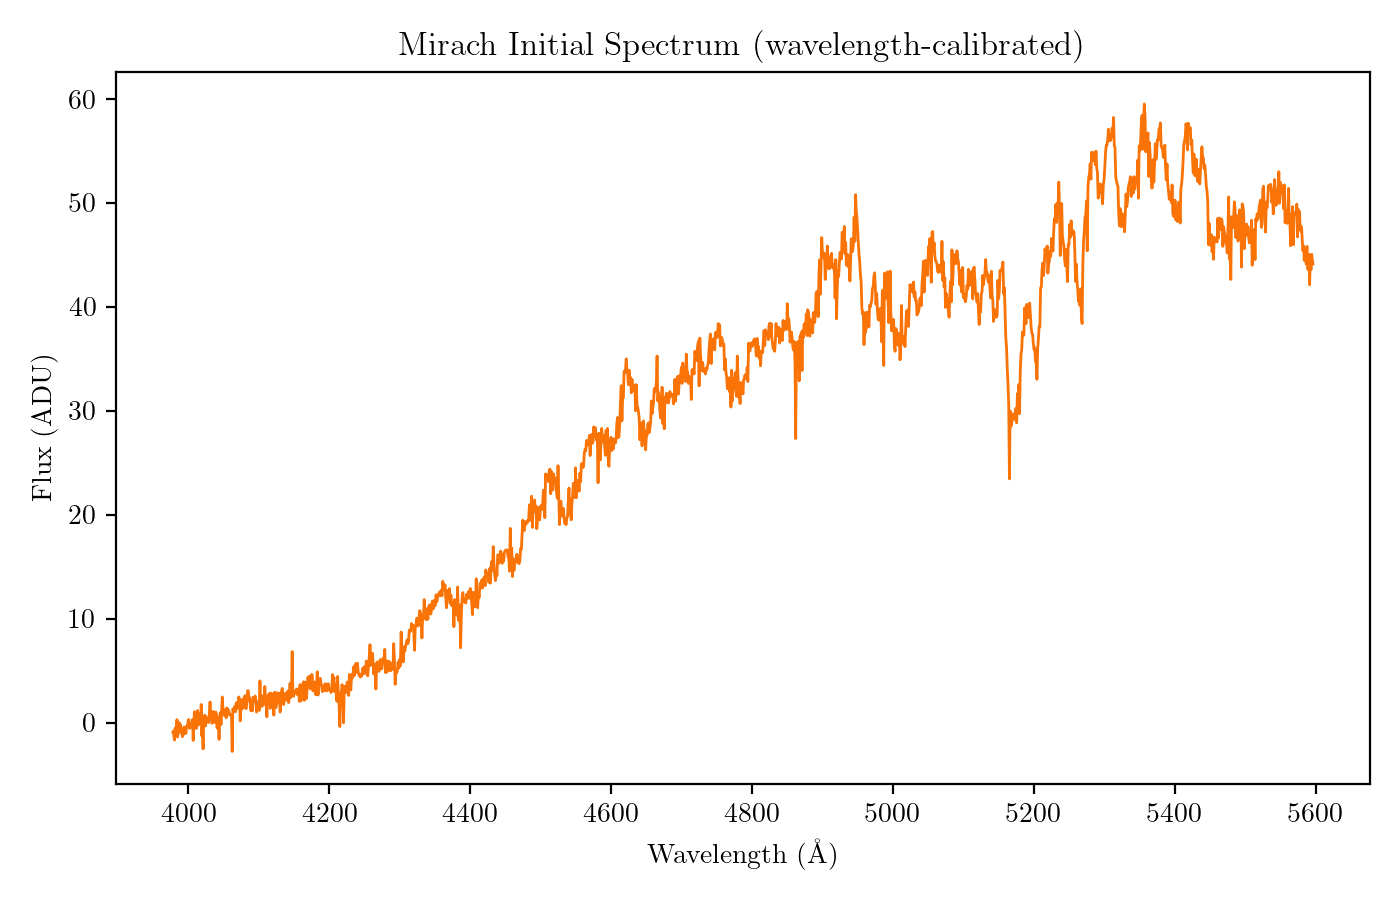

In [360]:
plot_cal_spectrum(aldebaran_wavelength, aldebaran_collapsed, "Aldebaran", "ald_init.png")
plot_cal_spectrum(deneb_wavelength, deneb_collapsed, "Deneb", "den_init.png")
plot_cal_spectrum(mirach_wavelength, mirach_collapsed, "Mirach", "mir_init.png")

### 4. One of the stars should be a known late B or A star. Use this as a telluric standard.

I grabbed these stellar types from Wikipedia. Aldebaran is a K5 type star. Deneb is an A2 type star. Mirach is an M0 type star. So, Deneb is our telluric standard.

### 5.1. Interpolate over absorption features in the telluric standard. 

In [265]:
def masked_spectrum(wv, spec, mask, ignore_masked=True):
    # Create a masked spectrum where absorption features are masked, as estimated by eye
    if ignore_masked == True:
        masked_wavelength = wv[~mask]
        masked_flux = spec[~mask]
    elif ignore_masked == False:
        masked_wavelength = wv[mask]
        masked_flux = spec[mask]       
    plt.figure(dpi = 100)
    plt.plot(masked_wavelength, masked_flux)
    plt.show
    return masked_wavelength, masked_flux

<IPython.core.display.Javascript object>


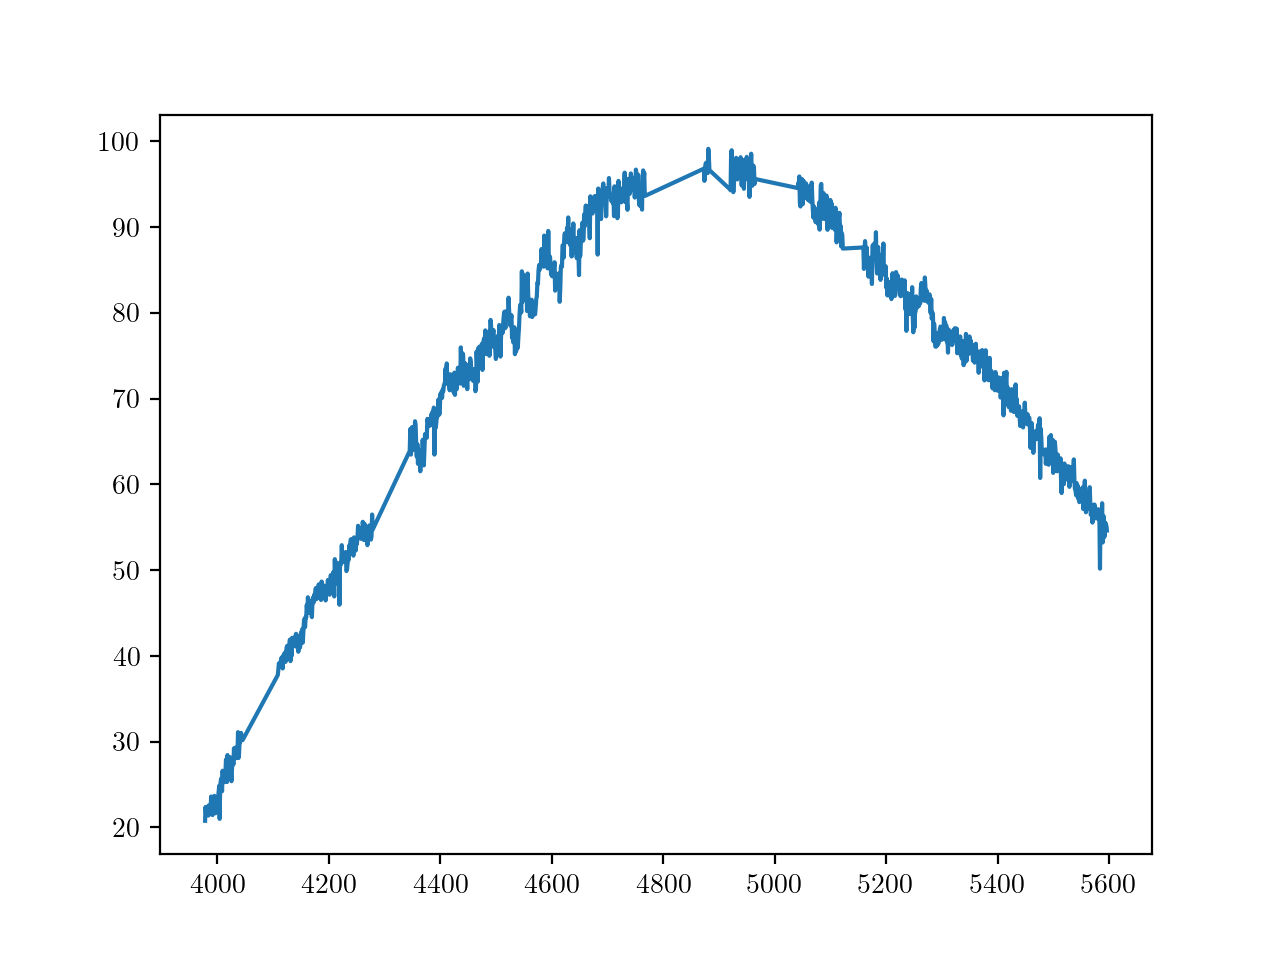

In [266]:
wv = deneb_wavelength
deneb_abs_mask = (wv>4046)&(wv<4108)|(wv>4279)&(wv<4345)|(wv>4768)&(wv<4872)|(wv>4883)&(wv<4919)|(wv>4965)&(wv<5041)|(wv>5123)&(wv<5159)
deneb_wavelength_masked, deneb_collapsed_masked = masked_spectrum(wv, deneb_collapsed, deneb_abs_mask)

In [243]:
def fit_spectrum(orig_wavelength, orig_flux, degree, star_name, masked_wavelength=None, masked_flux=None):
    # Fit a polynomial to a spectrum, masked or not masked; 
    # pass masked_wavelength and masked_flux if you want to mask
    if masked_wavelength is not None:
        fitting_wavelength = masked_wavelength
        fitting_flux = masked_flux
    else:
        fitting_wavelength = orig_wavelength
        fitting_flux = orig_flux
    coeffs = np.polyfit(fitting_wavelength, fitting_flux, deg=degree) # Fit a polynomial with wavelengths/fluxes
#     print(coeffs)
    polynomial = np.poly1d(coeffs)
    fitted_flux = np.polyval(polynomial, orig_wavelength) # Evaluate the polynomial at wavelengths
#     print(polynomial)
    plt.figure(dpi = 100)
    plt.plot(orig_wavelength, orig_flux, label='Spectrum') # Plot original spectrum
    plt.plot(orig_wavelength, fitted_flux, c='k', label='Polynomial fit') # Plot fit to spectrum
    plt.xlabel(r'Wavelength (\AA)')
    plt.ylabel(r'Flux (ADU)')
    plt.title(star_name+' Spectrum with fit (intensity versus wavelength)')
    plt.legend()
    plt.show()
    return fitted_flux

<IPython.core.display.Javascript object>


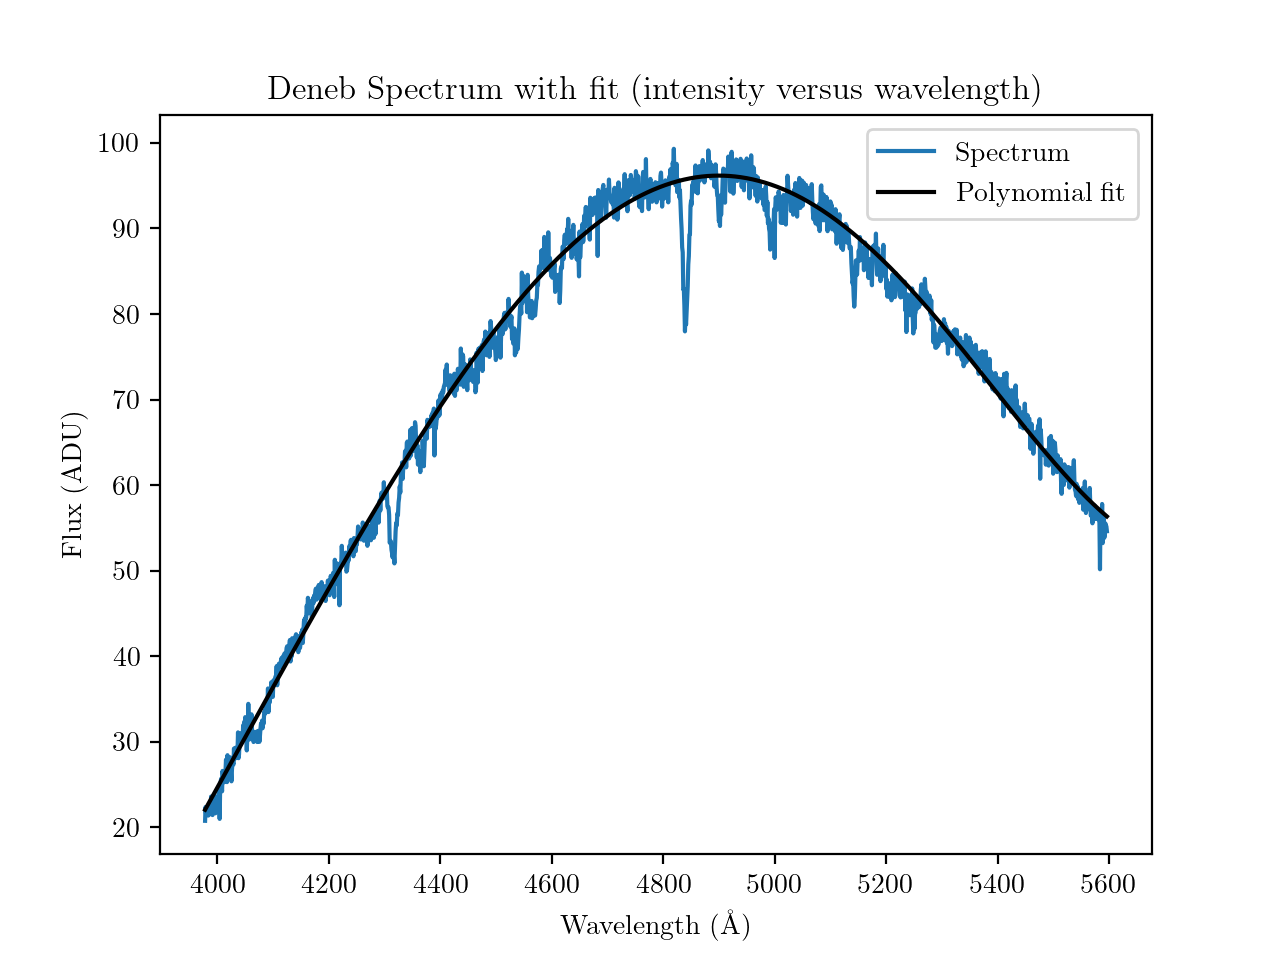

In [224]:
deneb_fit = fit_spectrum(deneb_wavelength, deneb_collapsed, 5, "Deneb",
                         masked_wavelength=deneb_wavelength_masked, masked_flux=deneb_collapsed_masked)

### 5.2. Divide each "target" spectrum by the telluric standard spectrum.

In [225]:
def plot_cal_ratio(wavelength, spectrum_collapsed, ratio):
    # Plot a spectrum against wavelength
    plt.figure(dpi = 100)
    plt.rc('font', family='serif')
    plt.plot(wavelength, spectrum_collapsed)
    plt.xlabel(r'Wavelength (\AA)')
    plt.ylabel(r'Flux ratio')
    plt.title(ratio+" (ratio versus wavelength)")
    plt.show()

<IPython.core.display.Javascript object>


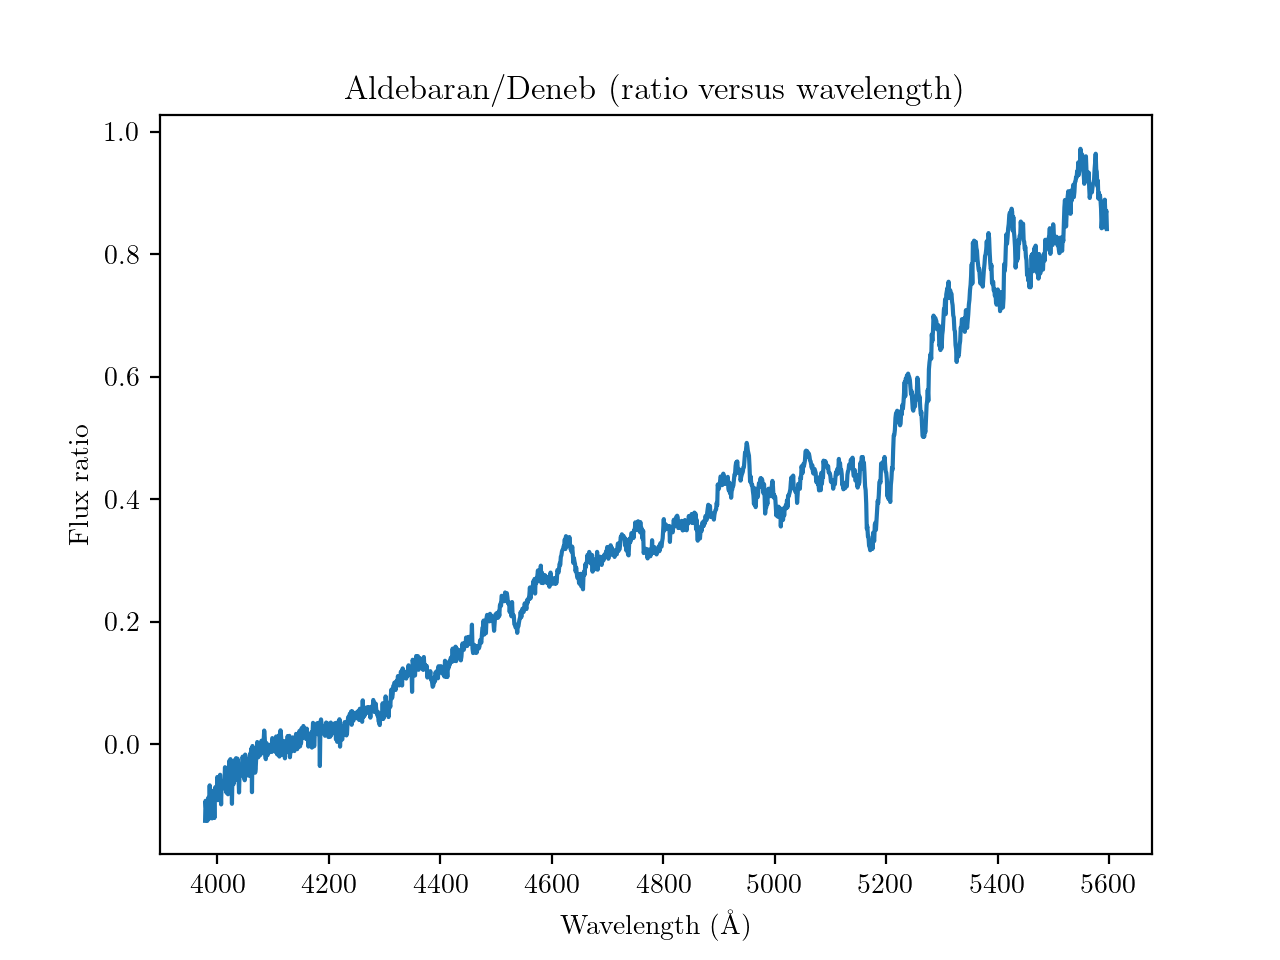

<IPython.core.display.Javascript object>


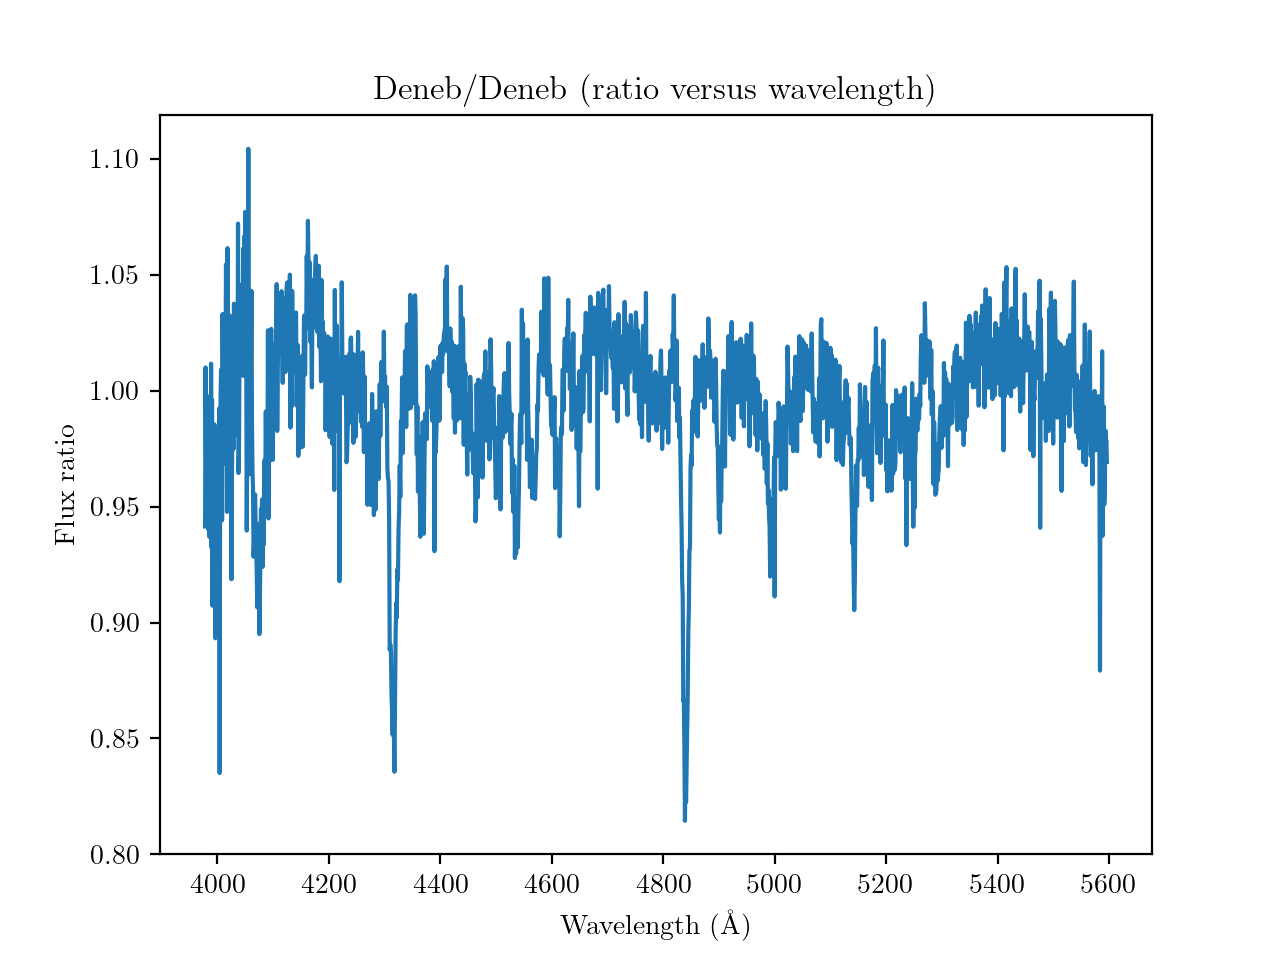

<IPython.core.display.Javascript object>


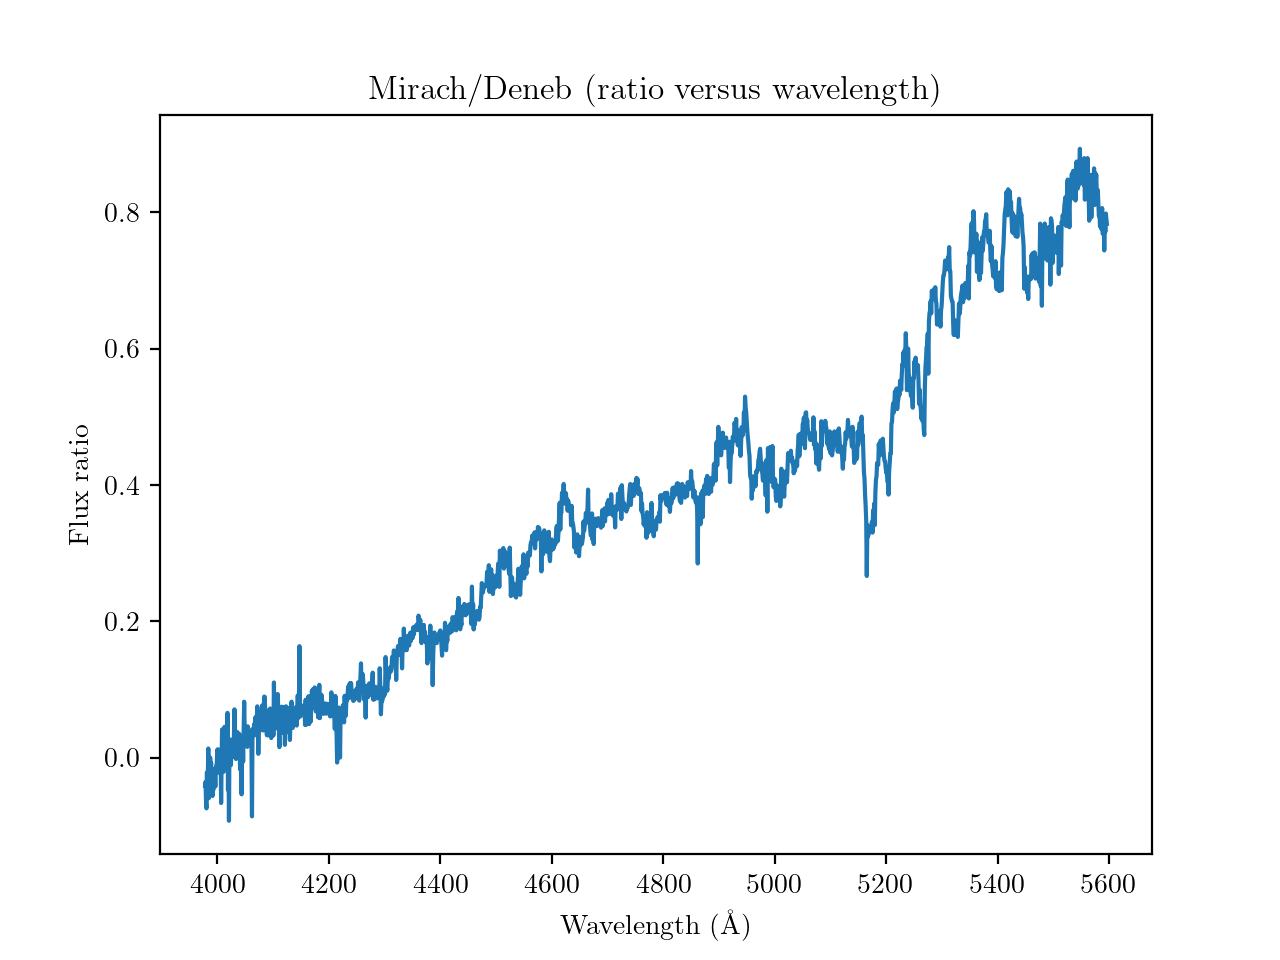

In [226]:
aldebaran_collapsed_div_deneb = aldebaran_collapsed/deneb_fit # Divide Aldebaran's spectrum by Deneb's (fit)
deneb_collapsed_div_deneb = deneb_collapsed/deneb_fit # Divide Deneb's spectrum by Deneb's (fit)
mirach_collapsed_div_deneb = mirach_collapsed/deneb_fit # Divide Mirach's spectrum by Deneb's (fit)

plot_cal_ratio(aldebaran_wavelength, aldebaran_collapsed_div_deneb, "Aldebaran/Deneb")
plot_cal_ratio(deneb_wavelength, deneb_collapsed_div_deneb, "Deneb/Deneb")
plot_cal_ratio(mirach_wavelength, mirach_collapsed_div_deneb, "Mirach/Deneb")

### 5.3. Multiply each target spectrum by a blackbody spectrum with the known temperature of the telluric standard.

<IPython.core.display.Javascript object>


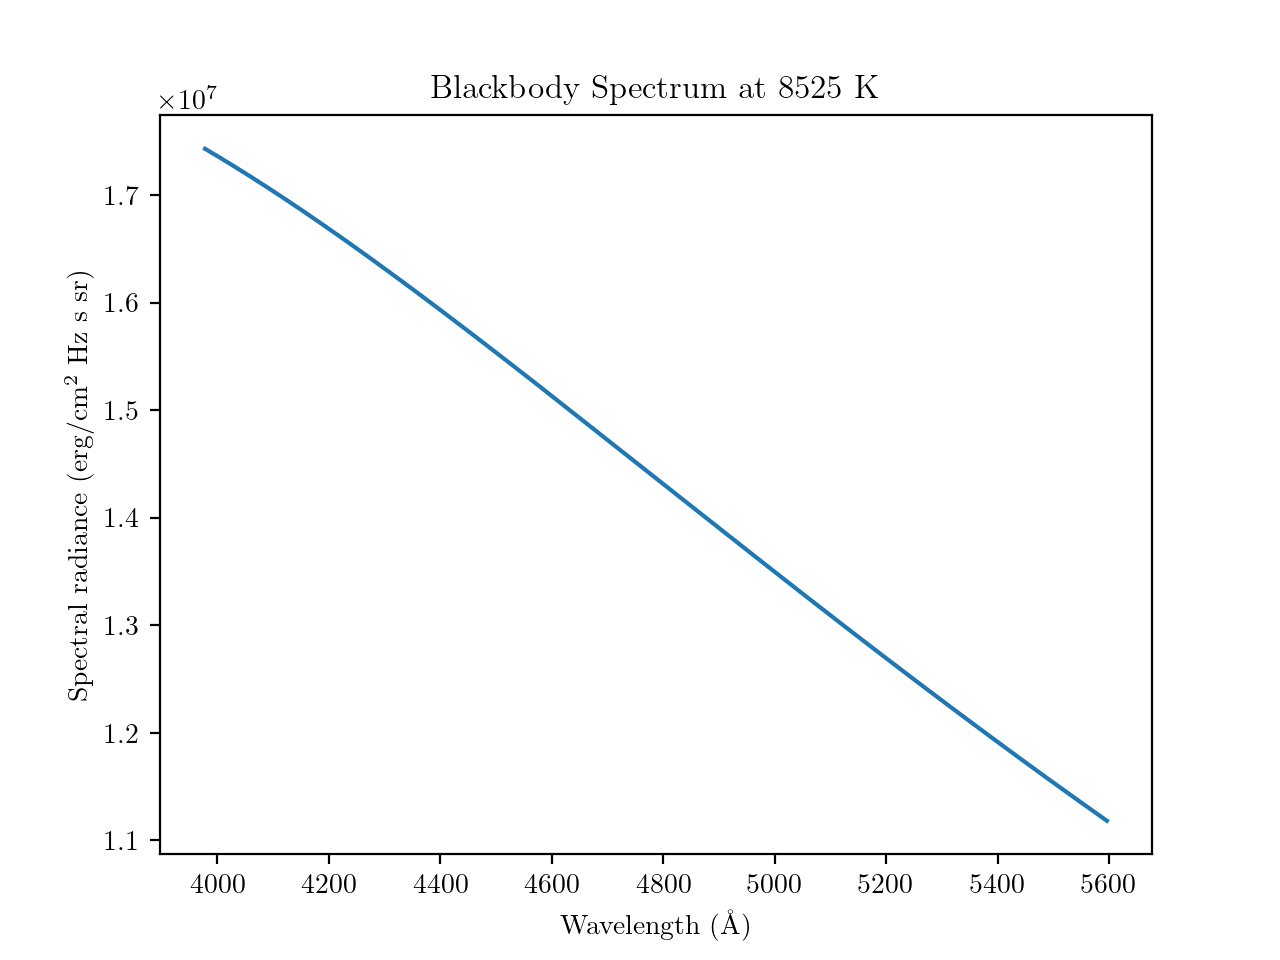

In [227]:
from astropy.modeling import physical_models
from astropy import units as u
from astropy import constants

def bb_spectrum(wavelength, temp):
    bb = physical_models.BlackBody(temperature=temp*u.K, scale=1.0*u.erg/(u.cm**2 *u.AA *u.s *u.sr))
    frequency = (wavelength*u.AA).to(u.Hz, equivalencies=u.spectral())  
    blackbody_spectrum = bb(frequency)  
    plt.figure(dpi = 100)
    plt.plot(wavelength, blackbody_spectrum)
    plt.title(r"Blackbody Spectrum at "+str(temp)+" K")
    plt.xlabel(r"Wavelength (\AA)")
    plt.ylabel(r"Spectral radiance (erg/cm\textsuperscript{2} Hz s sr)")
    plt.show()
    return blackbody_spectrum
    
deneb_bb = bb_spectrum(aldebaran_wavelength, 8525)

<IPython.core.display.Javascript object>


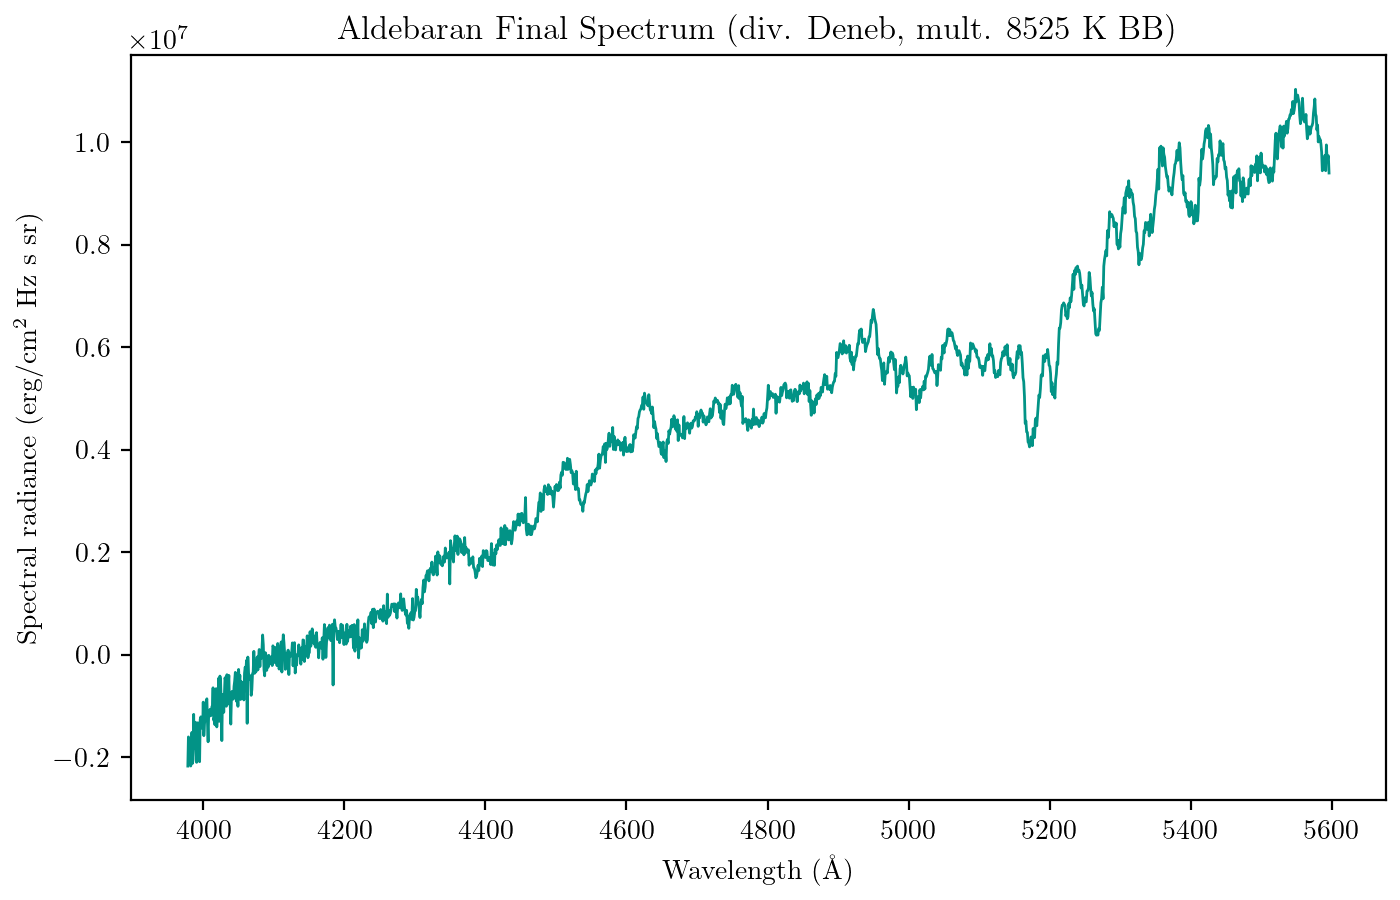

<IPython.core.display.Javascript object>


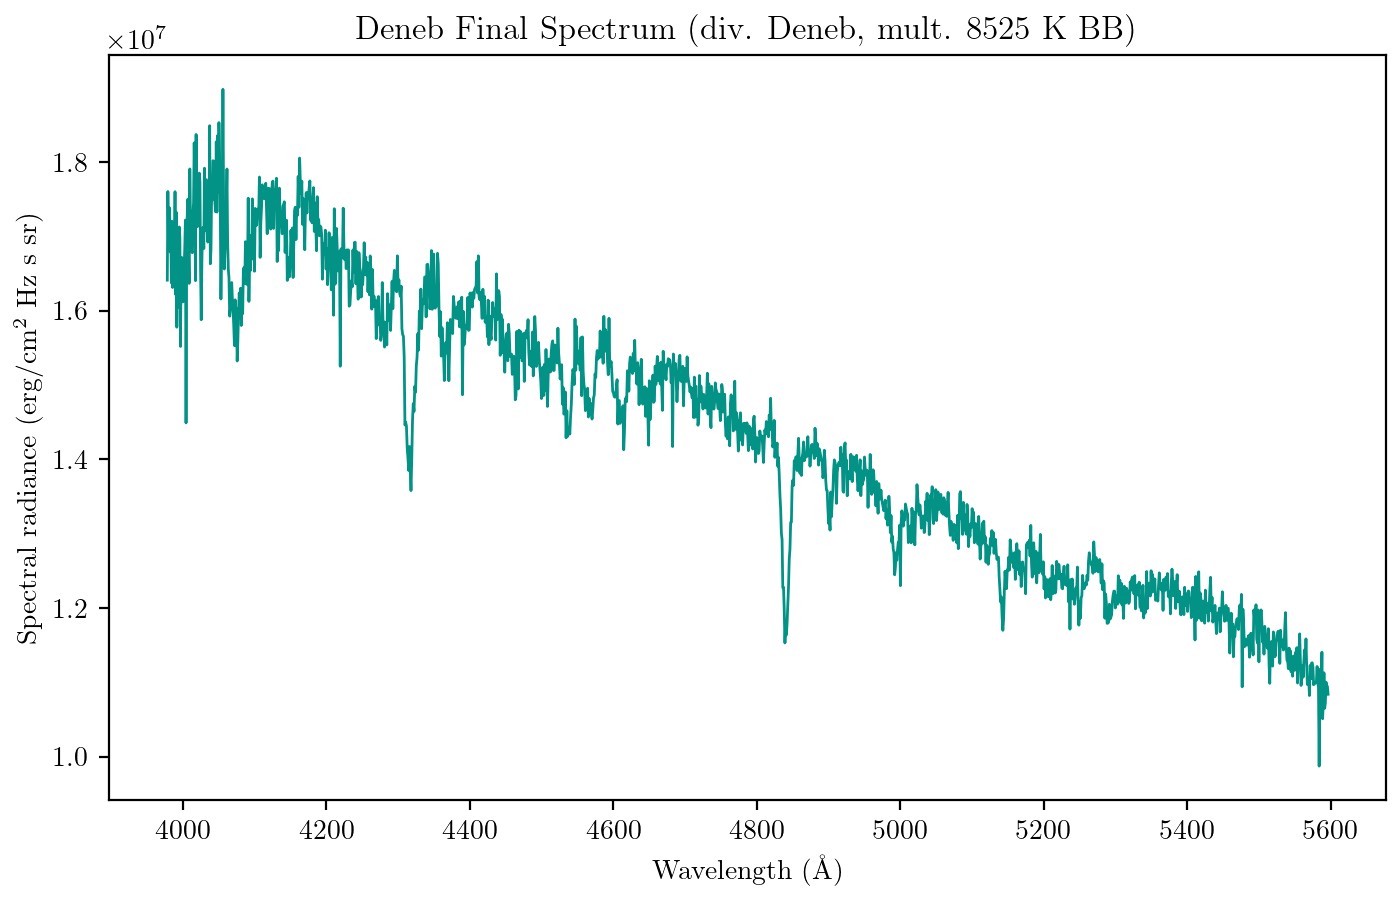

<IPython.core.display.Javascript object>


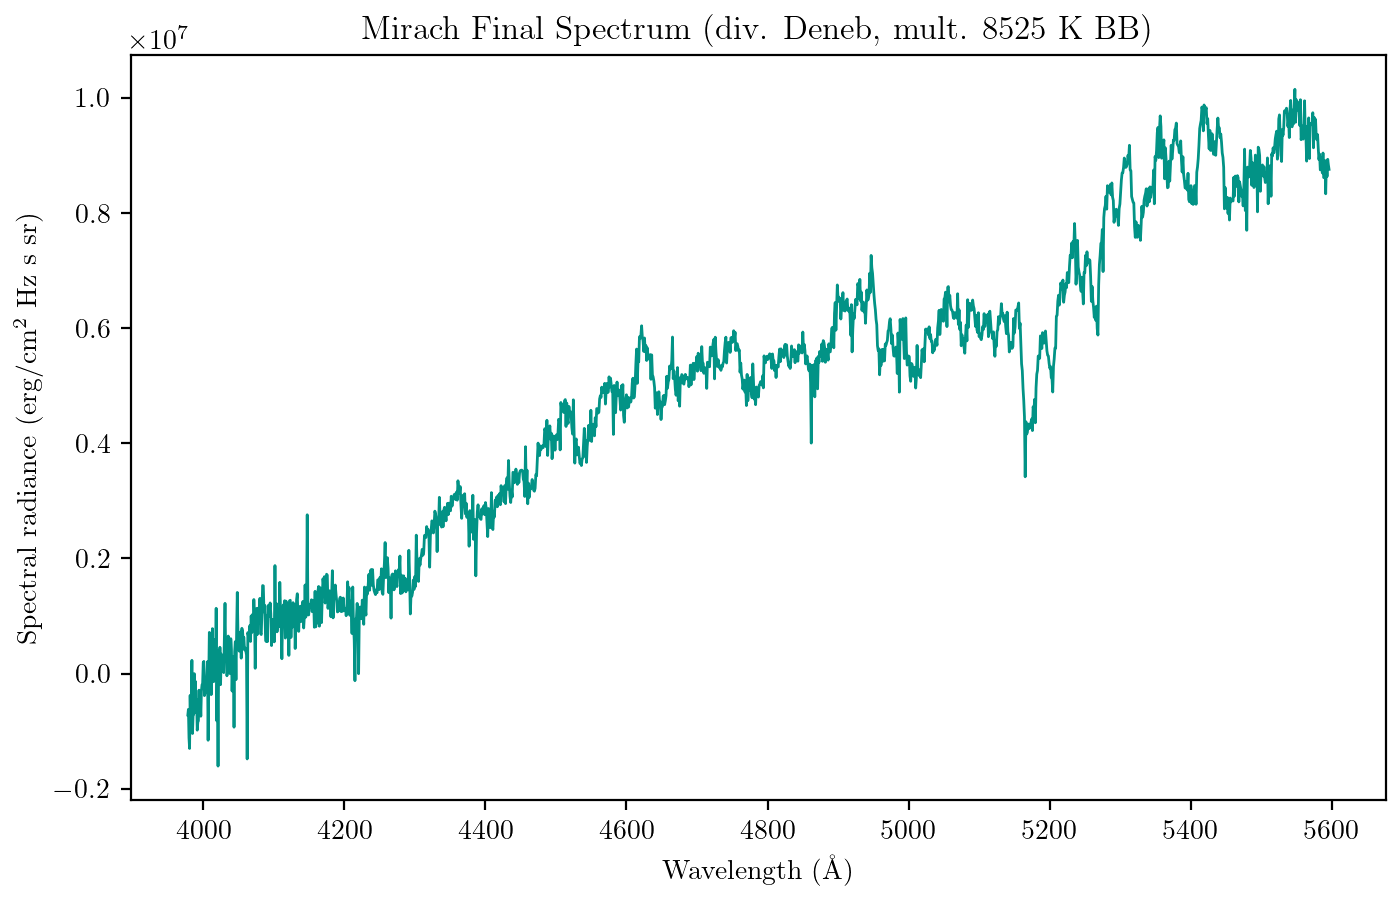

In [358]:
def final_spectrum(wavelength, collapsed_div, bb_spec, star_name, file_name):
    final_spec = collapsed_div*bb_spec
    plt.figure(dpi = 100, figsize=(7,4.5))
    plt.rc('font', family='serif')
    plt.plot(wavelength, final_spec, color='xkcd:teal', lw=1)
    plt.xlabel(r'Wavelength (\AA)')
    plt.ylabel(r"Spectral radiance (erg/cm\textsuperscript{2} Hz s sr)")
    plt.title(star_name+" Final Spectrum (div. Deneb, mult. 8525 K BB)")
    plt.tight_layout(pad=0.5)
    plt.savefig(file_name, dpi=250, facecolor='w', edgecolor='w')
    plt.show()
    return final_spec
    
aldebaran_fully_cal = final_spectrum(aldebaran_wavelength, aldebaran_collapsed_div_deneb, deneb_bb, "Aldebaran", "ald_fin.png")
deneb_fully_cal = final_spectrum(deneb_wavelength, deneb_collapsed_div_deneb, deneb_bb, "Deneb", "den_fin.png")
mirach_fully_cal = final_spectrum(mirach_wavelength, mirach_collapsed_div_deneb, deneb_bb, "Mirach", "mir_fin.png")

### 6. Your report should present spectra of each star. You should be able to get approximate stellar spectral types just from this.

The spectra appear in my report. My guesses for spectral types are as follows. Aldebaran and Mirach are cooler because of the direction of their slope in this wavelength region (peak redder than Deneb). Deneb has a lot of deep absorption lines, which are likely from hydrogen, indicating a B or A type star. My initial guess is that Aldebaran and Mirach are K or M type stars because of how much cooler they are than Deneb (slope is completely opposite sign).

### 7. Measure equivalent widths of key spectral features (i.e. Balmer lines, etc.). (Be sure to quote uncertainties. ) Use these to get more accurate spectral types by comparing to known values in the literature.

Our uncertainties on our wavelength measurements are 2 Angstroms. I'll fit a polynomial to each spectrum and divide by it to get the continuum level close to zero. Then, I'll fit Gaussians to the hydrogen Balmer series lines I can find.

<IPython.core.display.Javascript object>


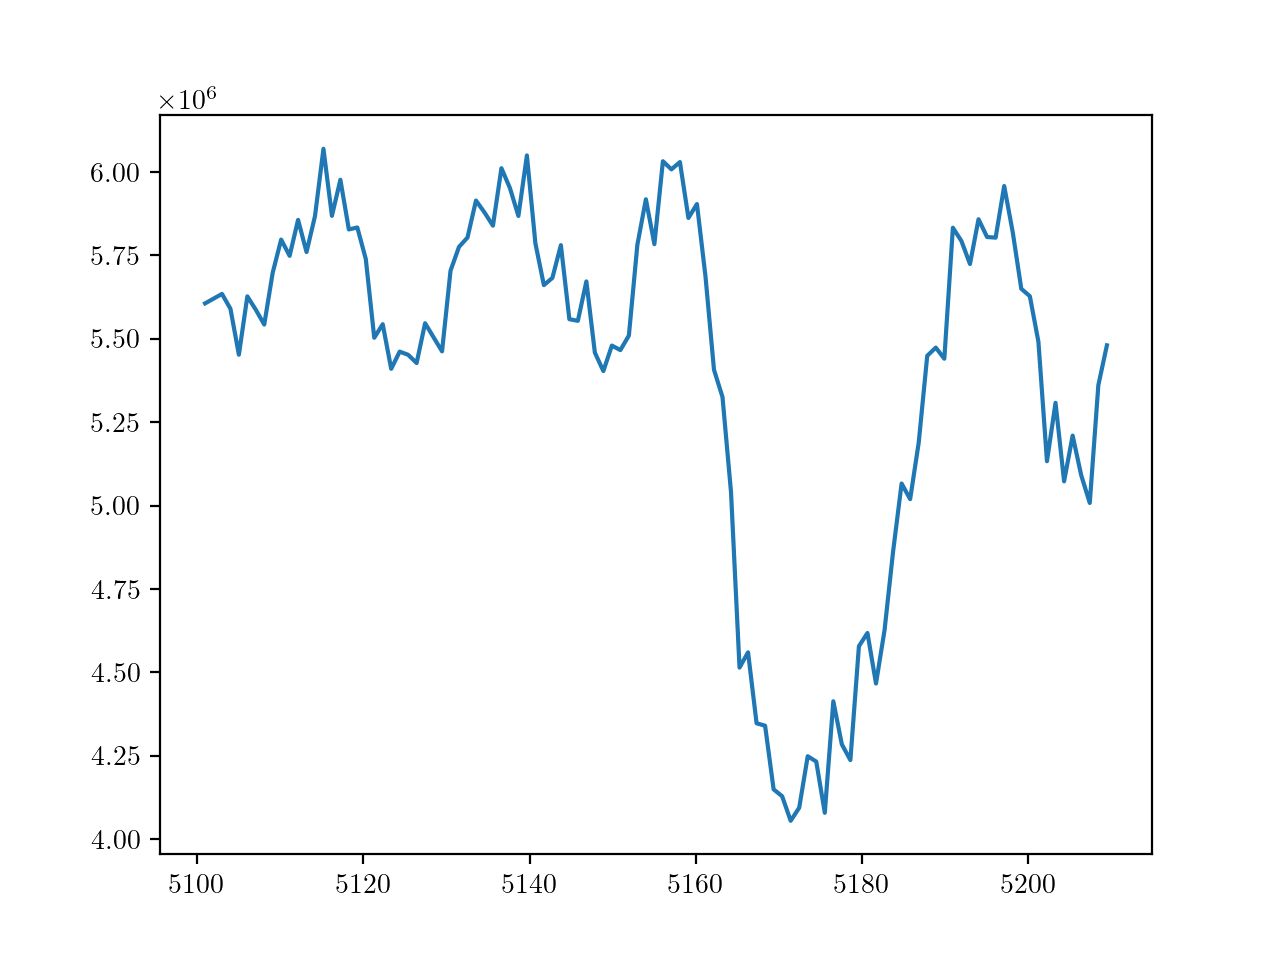

<IPython.core.display.Javascript object>


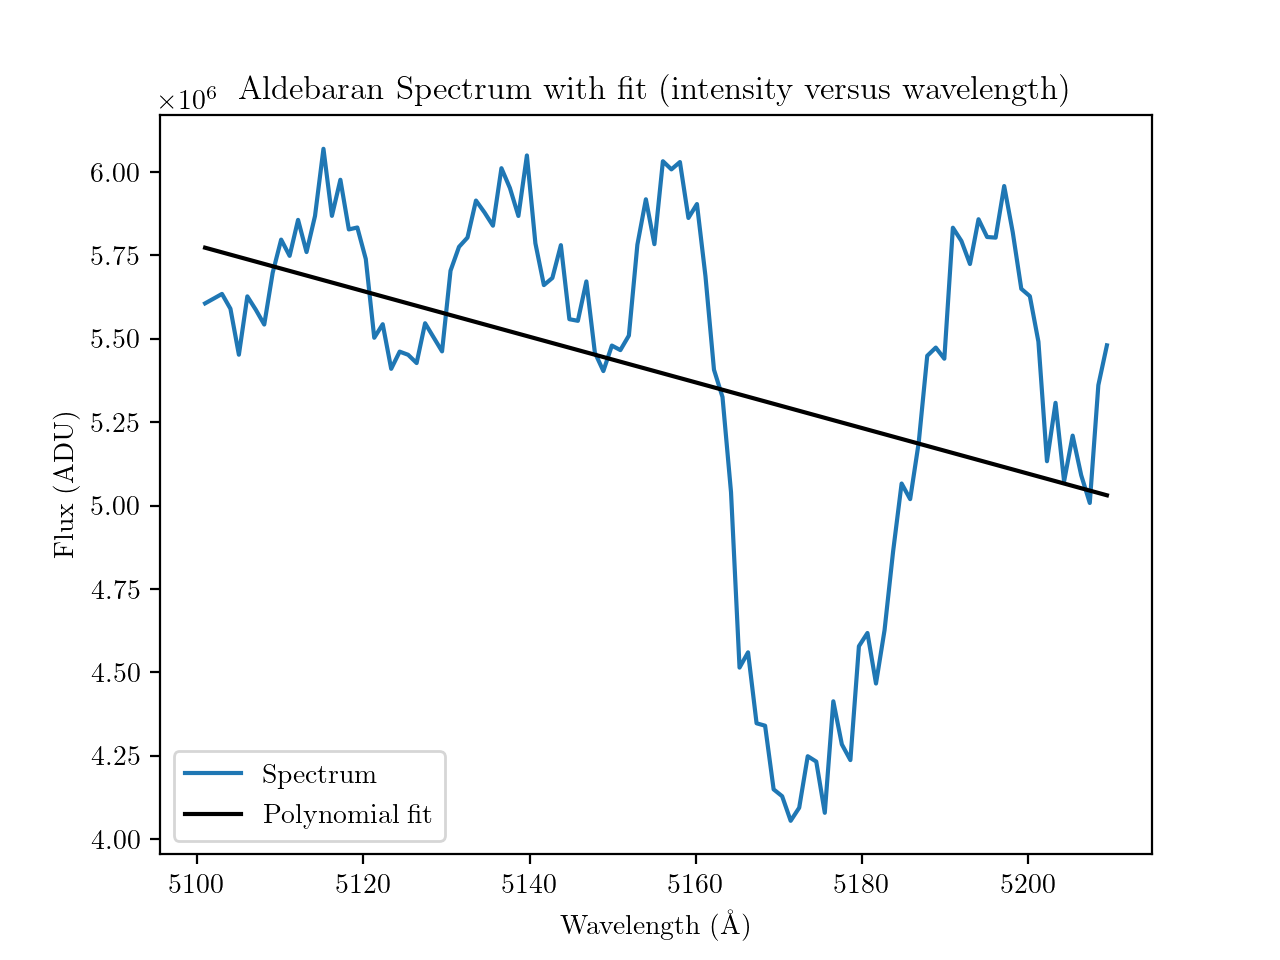

In [271]:
wv = aldebaran_wavelength
ald_tio_mask = (wv>5100)&(wv<5210)
ald_tio_wavelength_masked, ald_tio_spec_masked = masked_spectrum(wv, aldebaran_fully_cal,
                                                                 ald_tio_mask, ignore_masked=False)

ald_tio_fit = fit_spectrum(ald_tio_wavelength_masked, ald_tio_spec_masked, 1, "Aldebaran")

In [258]:
# aldebaran_fit_final = fit_spectrum(aldebaran_wavelength, aldebaran_fully_cal, 7, "Aldebaran")
# deneb_fit_final = fit_spectrum(deneb_wavelength, deneb_fully_cal, 7, "Deneb")
# mirach_fit_final = fit_spectrum(mirach_wavelength, mirach_fully_cal, 7, "Mirach")